See [documentation](https://alleninstitute.github.io/sourcesep/00_simulations.html) for the phenomenological model

In [1]:
# Testing simulation class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from rich import print as pprint
sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

from sourcesep.sim import SimData
from sourcesep.utils.config import load_config

paths = load_config(dataset_key='all')
sim = SimData(T=72000, cfg_path=paths['root'] / "sim_config.toml")

Paths are for dataset tagged: all
Paths are for dataset tagged: all


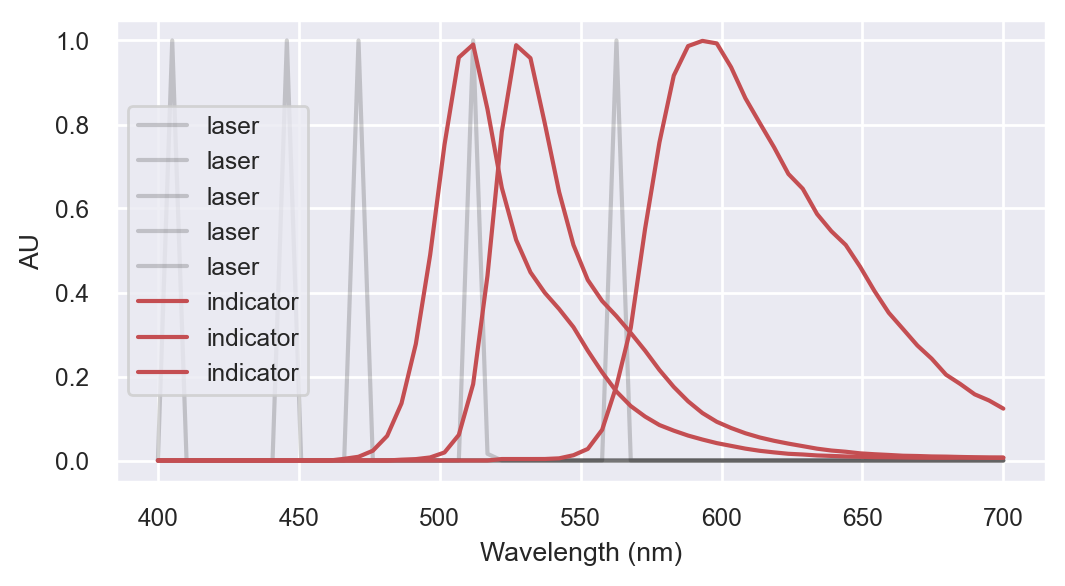

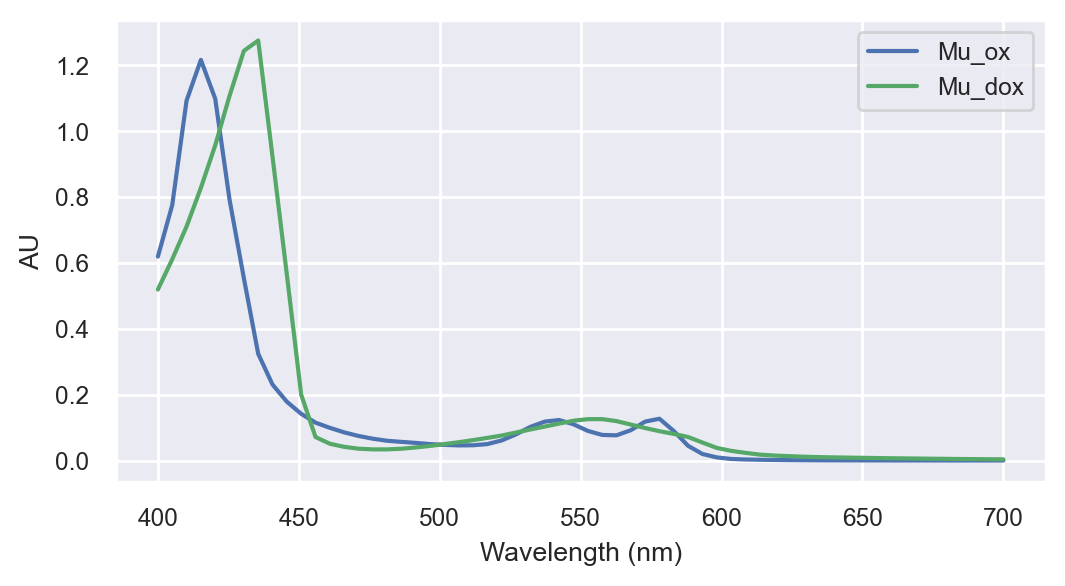

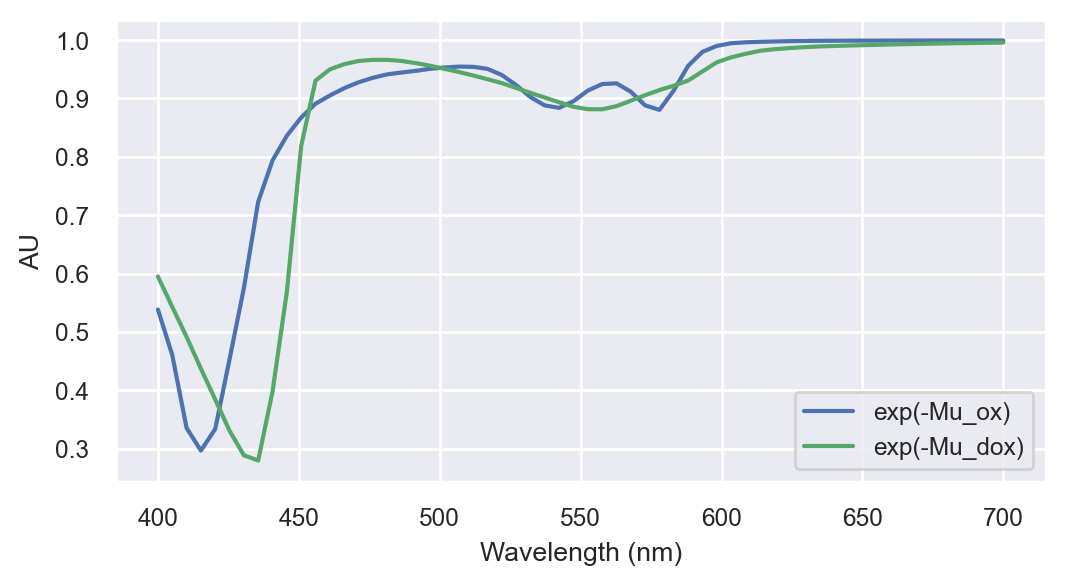

In [2]:
# indicator spectra S
# laser spectra E
# hemoglobin spectra Mu_ox, Mu_dox

S = sim.get_S()
W = sim.get_W()
E = sim.get_E()
Mu_ox, Mu_dox = sim.get_Mu()

f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, sim.E.T,'k', alpha=0.2, label='laser')
ax.plot(sim.L_arr, sim.S.T,'r', label='indicator')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, sim.Mu_ox, 'b',label='Mu_ox')
ax.plot(sim.L_arr, sim.Mu_dox, 'g',label='Mu_dox')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()


f, ax = plt.subplots(figsize=(6,3))
ax.plot(sim.L_arr, np.exp(-1*sim.Mu_ox), 'b',label='exp(-Mu_ox)')
ax.plot(sim.L_arr, np.exp(-1*sim.Mu_dox), 'g',label='exp(-Mu_dox)')
ax.set(xlabel='Wavelength (nm)', ylabel='AU')
plt.legend()
plt.show()

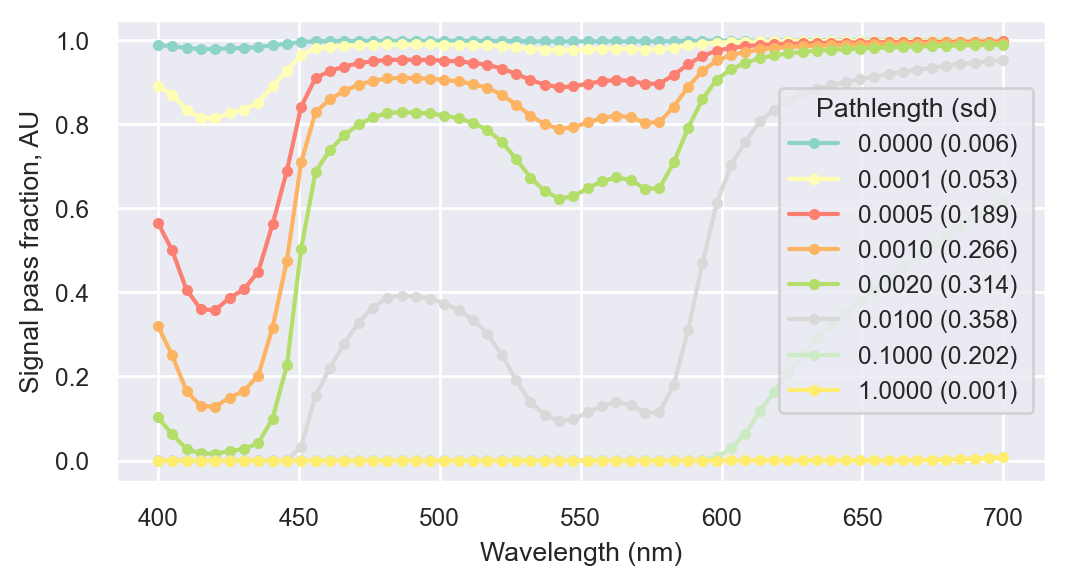

In [3]:
# The hemodynamic term attenuates the signal by a factor of exp(- (Mu_dox * H_dox + Mu_ox * H_ox))
# H_ox and H_dox sum up to roughly 1 at all time points
# Mu_ox and Mu_dox terms contain a heuristically set pathlength (see docs, modeling hemodynamics section)
# pathlength is set to roughly maximize variation (across wavelengths) in the [0,1] range

pathlength = sim.cfg['hemodynamics']['pathlength']

cmap = plt.get_cmap('Set3', lut=8)
f, ax = plt.subplots(figsize=(6,3))
for i, multiplier in enumerate([0.01, 0.1, 0.5, 1, 2, 10, 100, 1000]):
    y = np.exp(-multiplier*sim.Mu_dox - multiplier*sim.Mu_ox)
    ax.plot(sim.L_arr, y, '.-' ,c=cmap(i), label=f'{multiplier*pathlength:0.4f} ({np.std(y):0.3f}) ')
ax.set(xlabel='Wavelength (nm)', ylabel='Signal pass fraction, AU')
plt.legend(title='Pathlength (sd)')
plt.show()


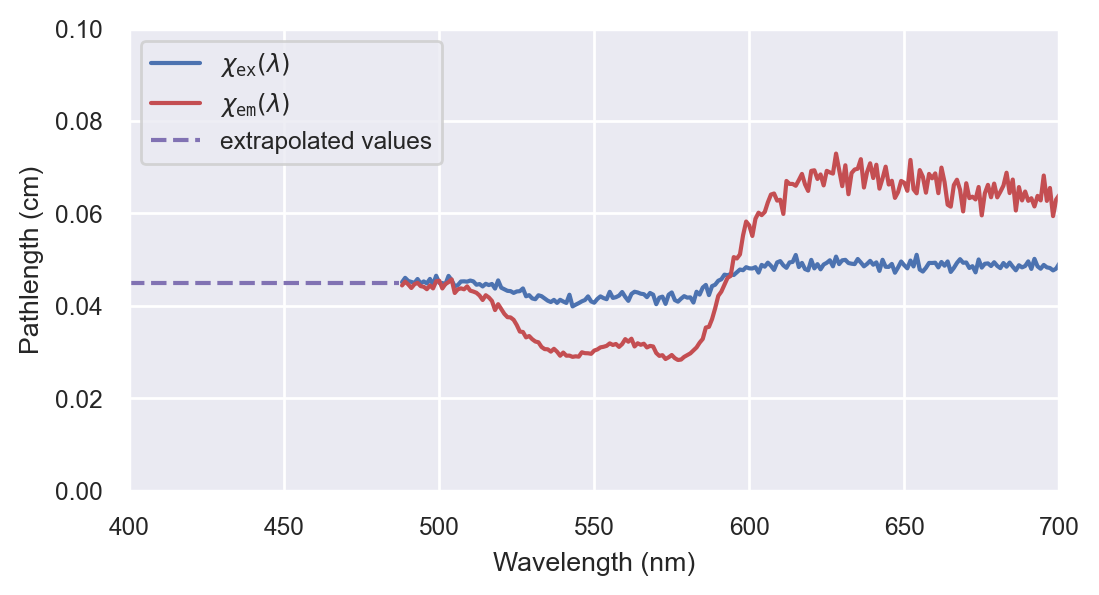

In [4]:
df = pd.read_csv(paths['spectra']/'2022_Zhang_Ex_Em_pathlengths.csv')
df.columns = ['wavelength', 'Xex', 'Xem']

exterpx = np.arange(400,488)
exterpy = np.ones_like(exterpx) * 0.045

f, ax = plt.subplots(figsize=(6,3))
ax.plot(df.wavelength, df.Xex, c='b',label=r'$\chi_{\tt{ex}}(\lambda)$')
ax.plot(df.wavelength, df.Xem, c='r',label=r'$\chi_{\tt{em}}(\lambda)$')
ax.plot(exterpx, exterpy ,'--m',label=r'extrapolated values')
ax.set(xlabel='Wavelength (nm)', ylabel='Pathlength (cm)', xlim=(400,700), ylim=(0,.1))
plt.legend()
plt.show()

In [5]:
# emission efficiency W
pprint(sim.W_df)

405     445     473     514     561
EGFP    0.1732  0.3915  0.8143  0.1469  0.0043
Venus   0.0572  0.0505  0.2174  1.0000  0.0000
mApple  0.0069  0.0294  0.0920  0.3863  0.8972

activity generation took 22.22ms


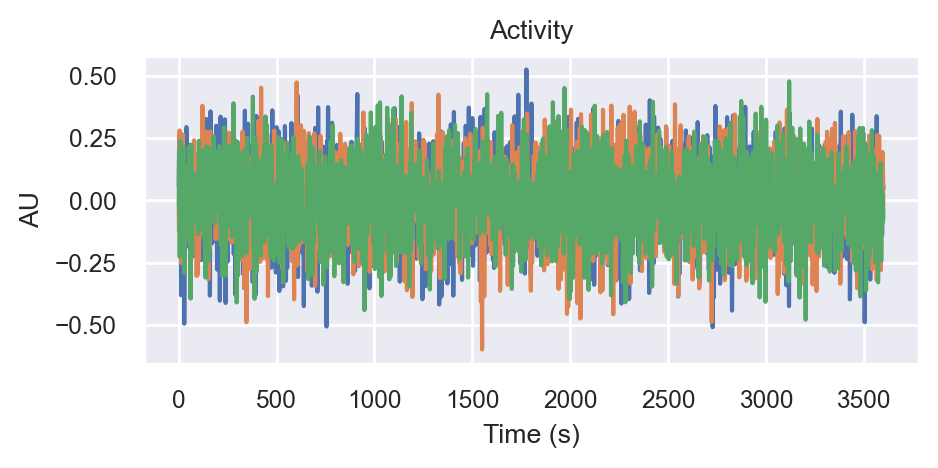

In [6]:
# example activity trace
with timebudget('activity generation'):
    A = sim.gen_A_slow(how='random_lowpass')

_, ax = plt.subplots(figsize=(5,2))
plt.plot(sim.T_arr, A)
ax.set(xlabel='Time (s)', ylabel='AU', title='Activity')
plt.show()

In [7]:
# sample generation time cost
with timebudget('20s sample (1k points)'):
    for i in range(1):
        dat = sim.compose()

20s sample (1k points) took 1.968sec


In [8]:
dat['O'].shape

(72000, 5, 60)

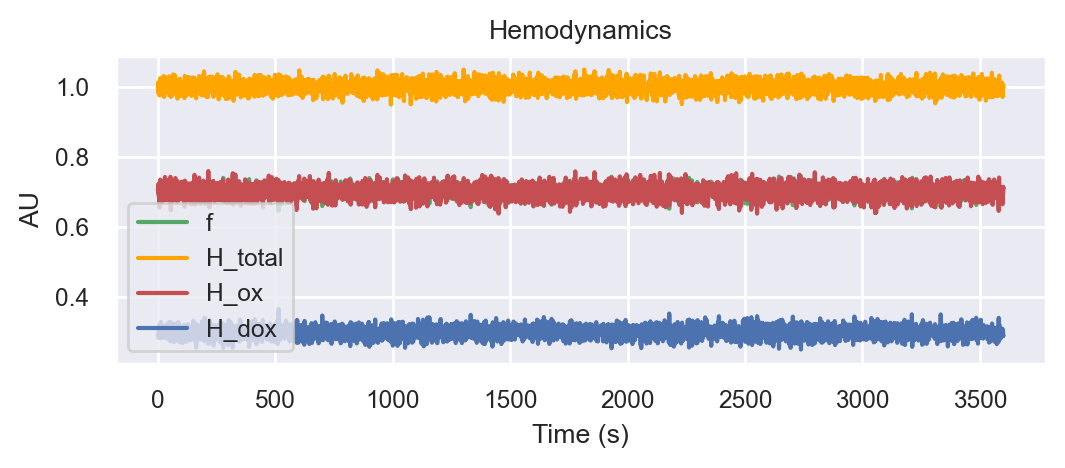

In [9]:
H_ox, H_dox, H_total, f = sim.gen_H()

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(sim.T_arr, f, c='g', label='f')
ax.plot(sim.T_arr, H_total, c='orange', label='H_total')
ax.plot(sim.T_arr, H_ox, c='r', label='H_ox')
ax.plot(sim.T_arr, H_dox, c='b', label='H_dox')
ax.set(xlabel='Time (s)', ylabel='AU', title='Hemodynamics')
plt.legend()
plt.show()

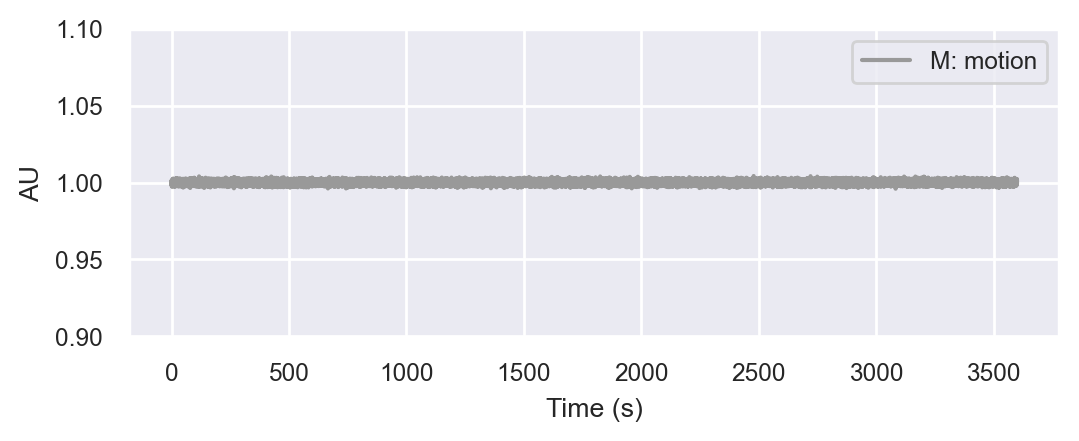

In [10]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['M'], c='#999999',label='M: motion')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[0.9, 1.1])
plt.legend()
plt.show()

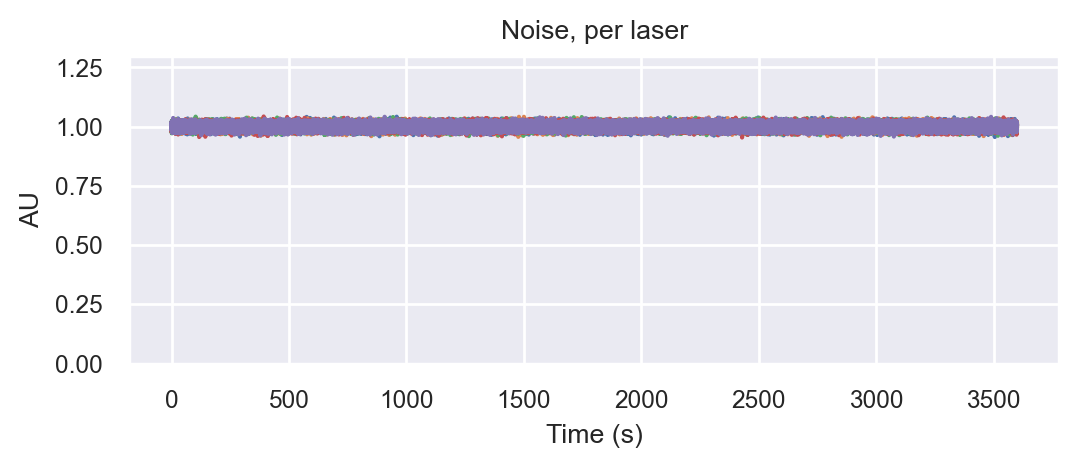

In [11]:
f, ax = plt.subplots(figsize=(6, 2))
ax.plot(sim.T_arr, dat['N'])
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[0, 1.3], title='Noise, per laser')
plt.show()

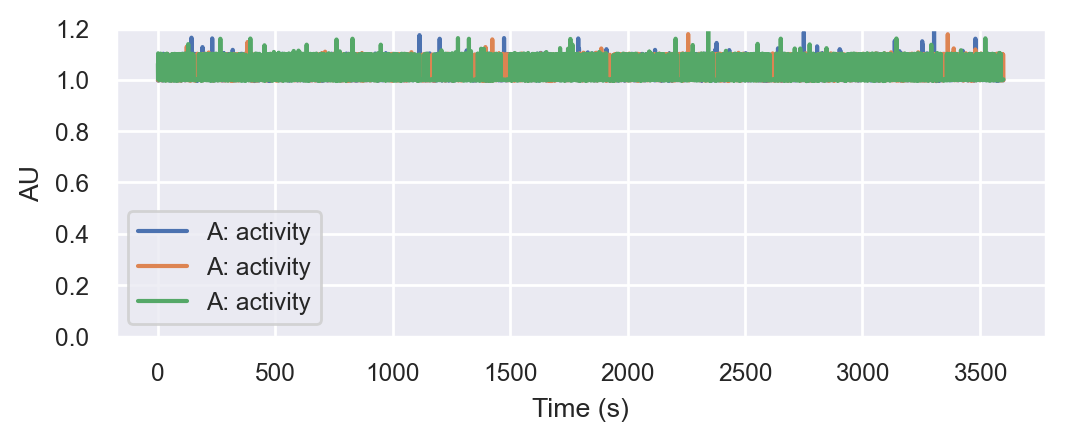

In [12]:
f, ax = plt.subplots(figsize=(6,2))
ax.plot(sim.T_arr, dat['A'],label='A: activity')
ax.set(xlabel='Time (s)', ylabel='AU', ylim=[0, 1.2])
plt.legend()
plt.show()

In [13]:
pprint(sim.cfg['indicator'].keys())
pprint(sim.cfg['laser'])
pprint(dat['O'].shape)

dict_keys(['EGFP', 'Venus', 'mApple'])

{
    'l0': {'em_wavelength_nm': 405},
    'l1': {'em_wavelength_nm': 445},
    'l2': {'em_wavelength_nm': 473},
    'l3': {'em_wavelength_nm': 514},
    'l4': {'em_wavelength_nm': 561}
}

(72000, 5, 60)

22


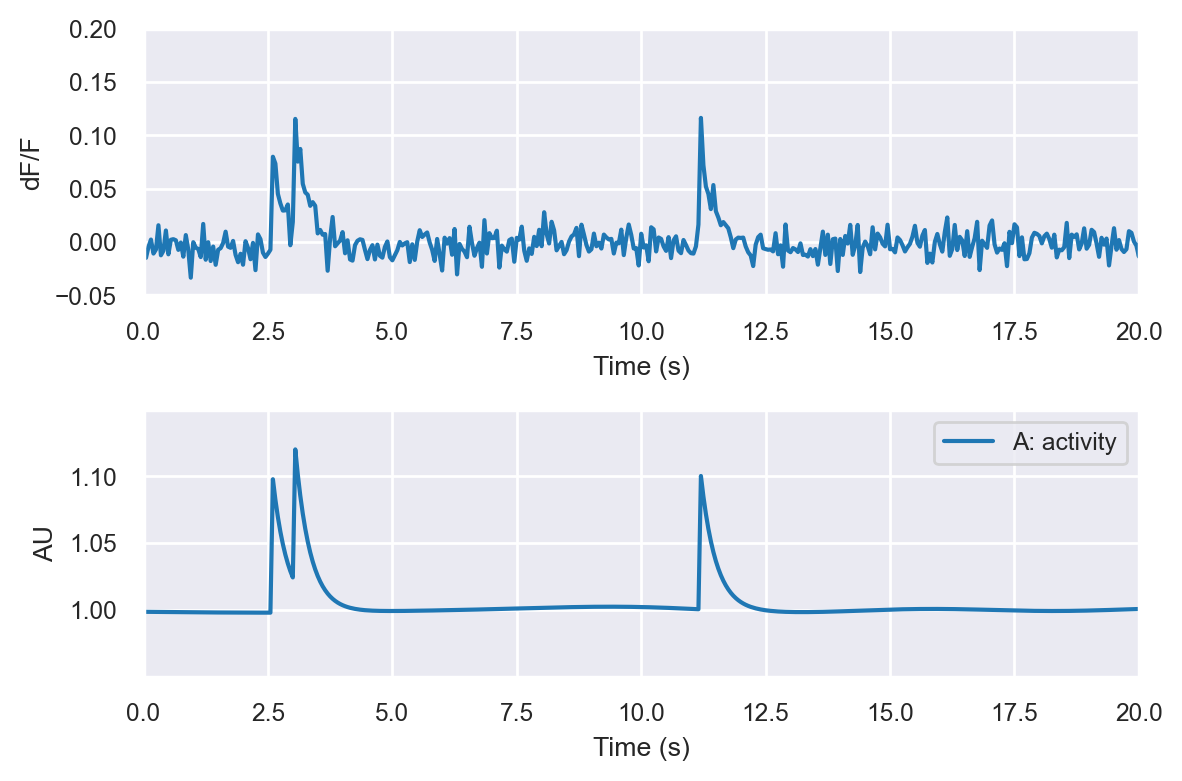

25


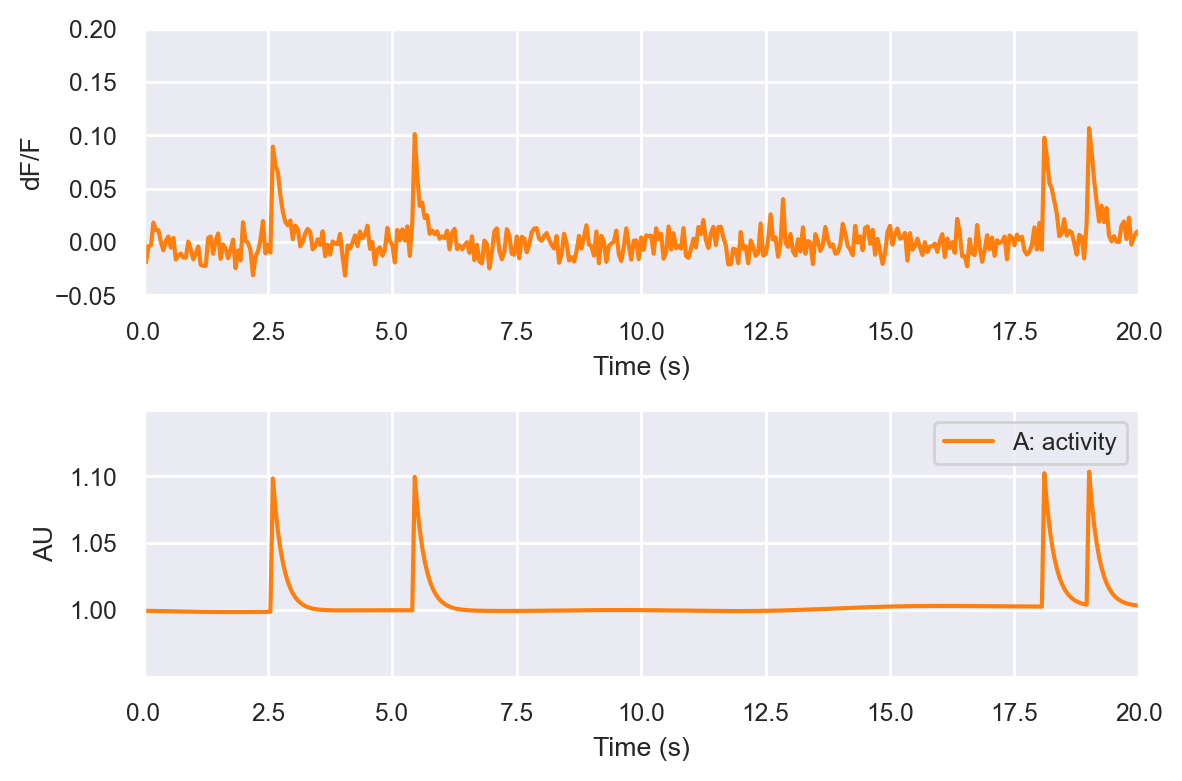

38


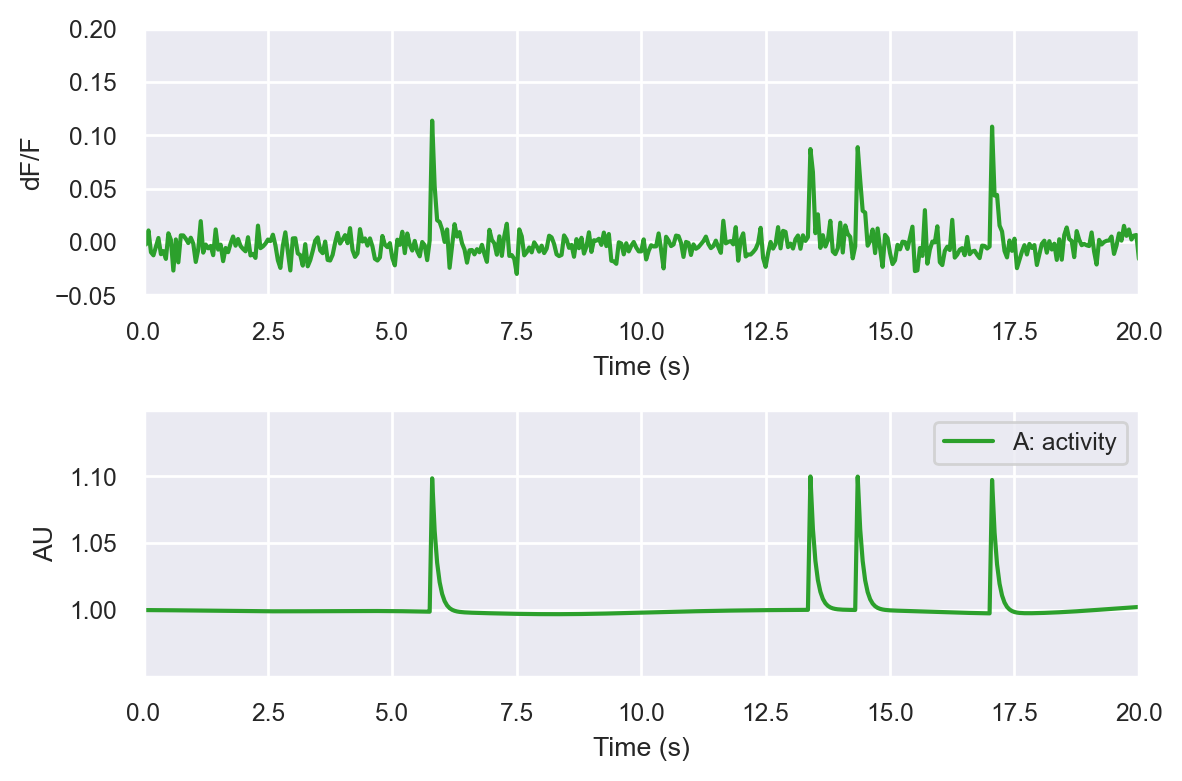

In [14]:
# This section is a check on how well the hardware separates sources
# dims are tjl for O
dat = sim.compose()

def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x)/mean_x


cmap = plt.get_cmap('tab10', lut=8)
for i,j,wavelength in [(0,2,510), (1,3,525), (2,4,591)]:
    # find index for closest wavelength
    l = np.argmin(np.abs(sim.L_arr - wavelength))
    print(l)

    f, ax = plt.subplots(2, figsize=(6, 4))
    ax[0].plot(sim.T_arr[:], df_over_f(dat['O'][:, j, l]), c=cmap(i), label=f'{sim.L_arr[l]:0.2f}')
    ax[0].set(xlabel='Time (s)', ylabel='dF/F', xlim=(0,20), ylim=(-0.05, 0.2))

    ax[1].plot(sim.T_arr, dat['A'][:, i], c=cmap(i), label='A: activity')
    ax[1].set(xlabel='Time (s)', ylabel='AU', xlim=(0,20), ylim=(0.95, 1.15), yticks=[1.0, 1.05, 1.1])
    plt.tight_layout()
    plt.legend()
    plt.show()


In [15]:
#sim.T_arr, 
T, J, L = np.shape(dat['O'])

In [16]:
def coef_fn(x,y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c

In [17]:
coef_list = []
for j in range(J):
    coef = np.empty((L,L))
    coef[:] = np.nan
    for l1 in range(L):
        for l2 in range(l1,L):
            coef[l1,l2] = coef_fn(dat['O'][:,j,l1], dat['O'][:,j,l2])
    coef_list.append(coef)

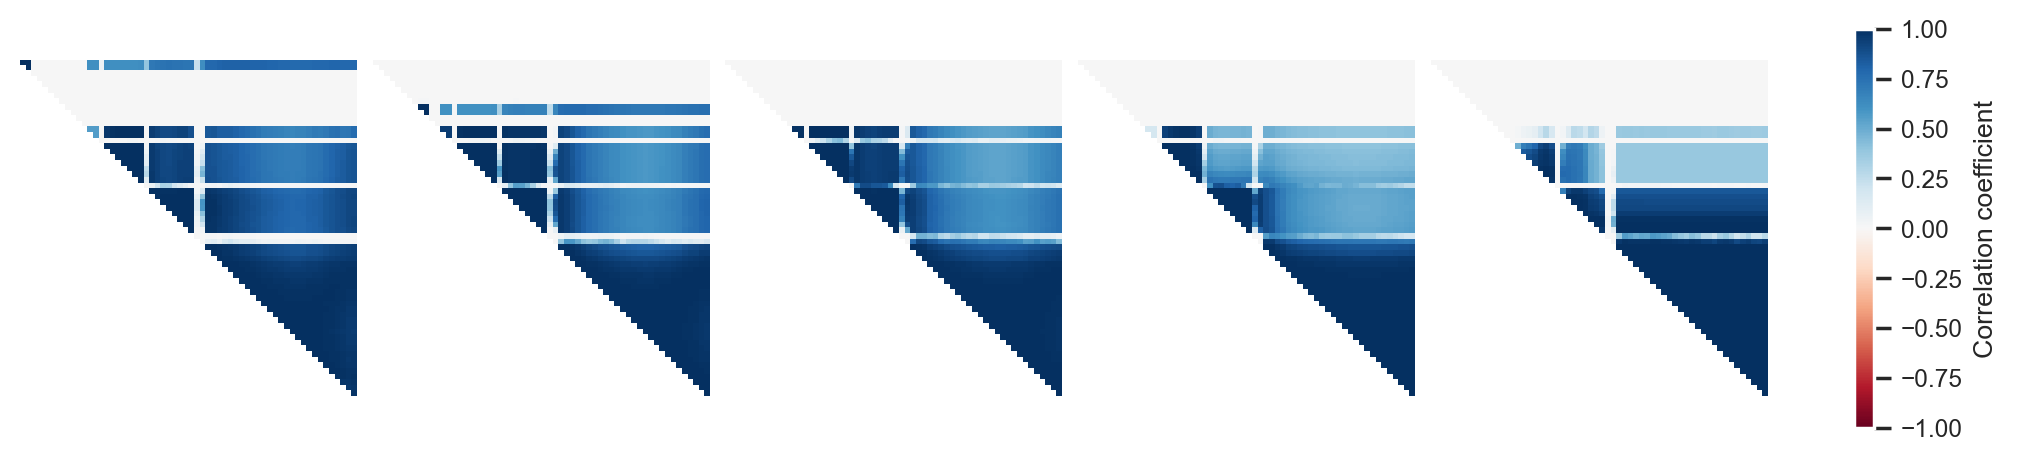

In [18]:
# signals are correlated across wavelengths
# this is shown for each laser-channel
# a distinct pattern is also observed at the laser emission wavelength
# the block diagonal arises from the signal being dominated by the different sensors in different spectral blocks
cmap = plt.get_cmap('RdBu').copy()
cmap.set_bad(color='w', alpha=1.)
f, ax = plt.subplots(1, J, figsize=(10, 10*J), constrained_layout=True)
for j in range(J):
    i = ax[j].imshow(coef_list[j], vmin=-1, vmax=1, aspect=1, cmap=cmap)
    ax[j].axis('off')
    ax[j].grid(False)
f.colorbar(i, ax=ax[:], location='right', shrink=0.04,
           label='Correlation coefficient')
plt.show()

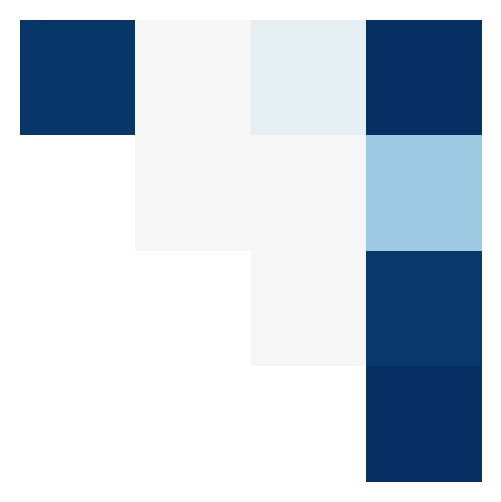

In [19]:
cmap = plt.get_cmap('RdBu').copy()
cmap.set_bad(color='w', alpha=1.)
f, ax = plt.subplots(1,1,figsize=(3,3))
i = ax.imshow(coef_list[4][30:34,30:34], vmin=-1, vmax=1, aspect=1, cmap=cmap)
ax.axis('off')
ax.grid(False)


[552.54237288 557.62711864 562.71186441 567.79661017]

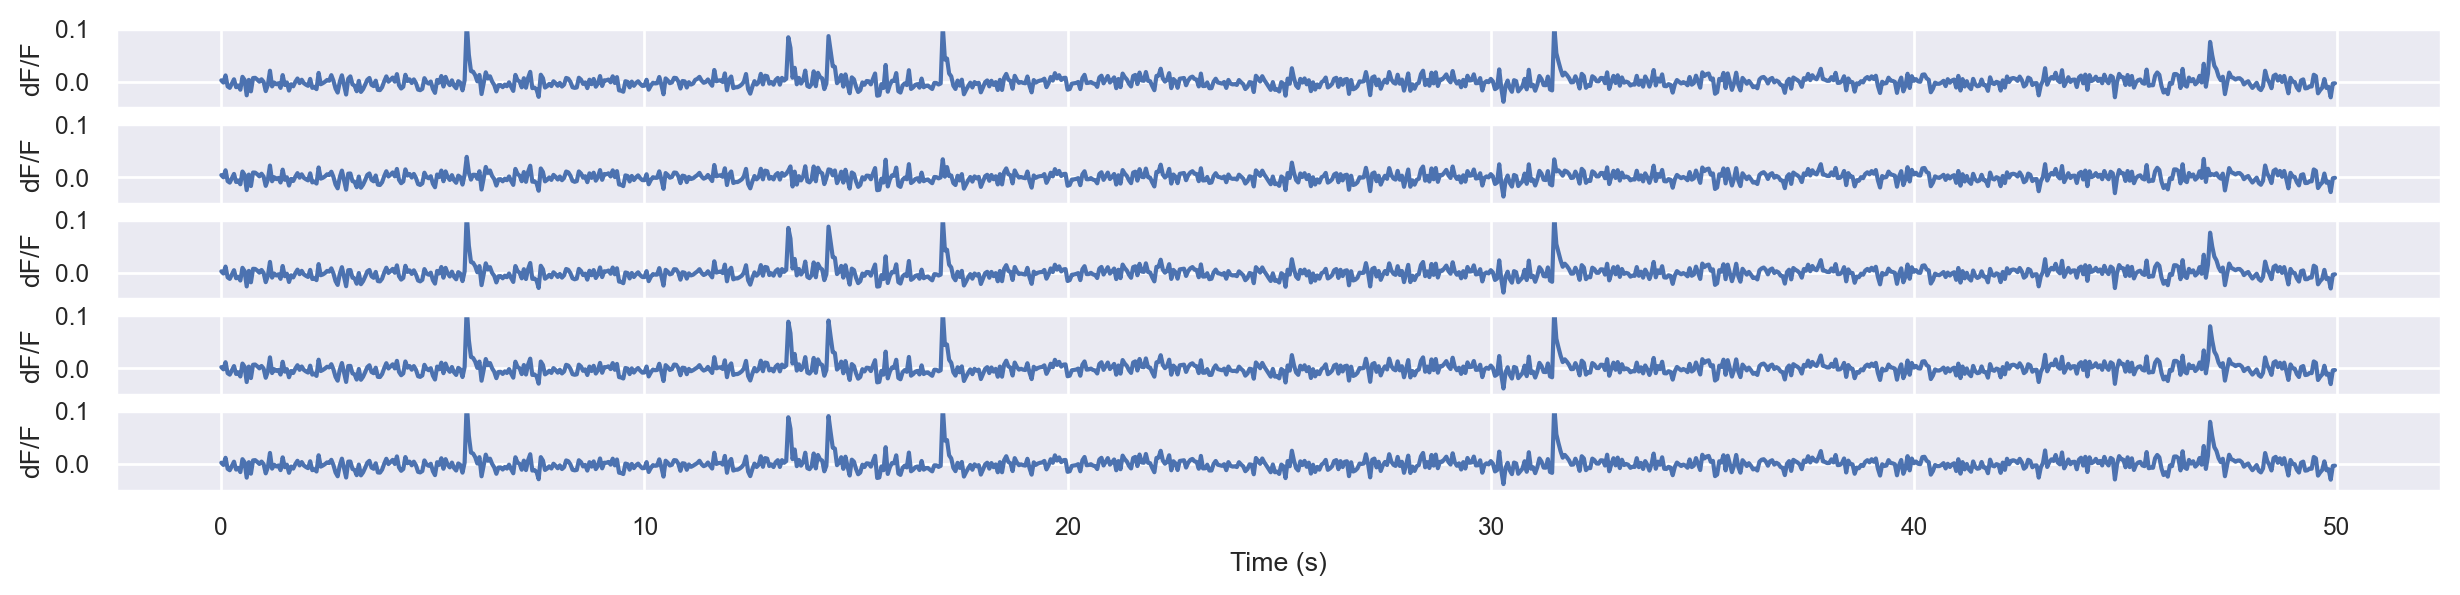

In [20]:
# zooming in to inspect the pattern around laser emission wavelengths
pprint(sim.L_arr[30:34])
f, ax = plt.subplots(5,1,figsize=(15,3))
for i,l in enumerate(range(30,35)):
    ax[i].plot(sim.T_arr[0:1000], df_over_f(dat['O'][0:1000,4,l]))
    ax[i].set(ylim=(-0.05,0.1), xlabel='Time (s)', ylabel='dF/F')
plt.show()